In [2]:
import re
import pandas as pd

## Import data
For initial training, import whole corpus. <br>
For pretraining to feed to sequential LDA model/tuned LDA model, import corpus for first quarter (i.e. July to September, Q1). Then, pre-train on first 3 months data; time_slice remaining months (Q2 to Q4). <br>
Change file path while importing accordingly.<br>


In [3]:
#Reading in data from
import os
import pandas as pd

# setting the path for file (full corpus)
#file_path = os.path.join("C:\\Users\\Abhinaya\\twint_scraped_data_non_zip\\final_tweets_ordered_2021to2022.csv")

# file path for Q1 data
file_path = os.path.join("C:\\Users\\Abhinaya\\twint_scraped_data_non_zip\\ordered\\Q1_JultoSept.csv")


#Create dataframe
new_df=pd.read_csv(file_path)
new_df['tweet']

0       @JustForJustice3 @signori_massimo @PiramideRos...
1       @signori_massimo @PiramideRossa @Lucacec71 @ra...
2       @giogioppi CiÃ² che sarÃ  assicurato saranno i...
3       @WRicciardi @VgaMaths @nytimes @Avvenire_Nei M...
4       Leggo per mestiere ma da mesi i miei occhi fun...
                              ...                        
4693    @Flaviaventosole Avere male al braccio, due li...
4694    @matteopredica @SaggioSergio @lorepregliasco P...
4695    @lillo_letterio @nexusSEI_6 @GhisleniGianni La...
4696    @la_bongia @non_rompere_i Altri effetti a lung...
4697    Il "long covid" è rarissimo, praticamente un m...
Name: tweet, Length: 4698, dtype: object

In [4]:
# In our project, we used Python re module to remove emojis, email addresses, URLs, and hash symbol 
# so that for instance, “#LongCovid” becomes “LongCovid”.

emoji_pattern = re.compile("["
   u"\U0001F600-\U0001F64F" # emoticons
   u"\U0001F300-\U0001F5FF" # symbols & pictographs
   u"\U0001F680-\U0001F6FF" # transport & map symbols
   u"\U0001F1E0-\U0001F1FF" # flags (iOS)
   u"\U00002702-\U000027B0"
   u"\U000024C2-\U0001F251"
   u"\U00002500-\U00002BEF" # chinese char
   u"\U0001f921-\U0001f937"
   u"\U00010000-\U0010ffff"
   u"\u2640-\u2642"
   u"\u2600-\u2B55"
   u"\u200d"
   u"\u23cf"
   u"\u23e9"
   u"\u231a"
   u"\ufe0f" # dingbats
   u"\u3030"
   "]+", flags=re.UNICODE)
email_pattern = re.compile("\S+@\S+\.\S{2,3}")
link_pattern = re.compile("https?\S+")
account_names_pattern=re.compile("@\w+")

In [5]:
def clean_data(tweet):
    try:
        tweet_rep = emoji_pattern.sub(r'', tweet)
        tweet_rep = email_pattern.sub(r'', tweet_rep)
        tweet_rep = link_pattern.sub(r'', tweet_rep)
        tweet_rep = tweet_rep.replace("[‘’“”]", "") #remove fancy quotes, second pass
        tweet_rep = tweet_rep.replace("…"," ") #replace ellipsis with single space, second pass
        tweet_rep = tweet_rep.replace("&amp;", "&")
        tweet_rep = tweet_rep.replace("#", '')
        tweet_rep = tweet_rep.replace("-", '') #remove hyphens, found on second pass
        tweet_rep = account_names_pattern.sub(r'', tweet_rep) #replace tagged Twitter accounts & mentions/usernames (i.e, all words starting with @ symbol)
        tweet_rep = tweet_rep.strip()
        return tweet_rep
    except:
        return ""



In [6]:
#Data cleaning of each tweet
clean_tweet_list=[]
for tweet in new_df.tweet:
    #print(i)
    clean_tweet=clean_data(tweet)
    clean_tweet_list.append(clean_tweet)
#print(clean_tweet_list)

In [7]:
#!python -m pip install h5py
#!python -m pip install wrapt
#!python -m pip install typing_extensions

In [8]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [9]:
#Installations needed on personal PC because of previous spaCy instance, not needed if a fresh install was performed
#!python -m pip install -U spacy --user
#!python -m spacy validate
#!python -m spacy download en_core_web_lg
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_md

In [10]:
# spacy for lemmatization
import spacy

In [11]:
# Initialize spacy 'it_core_news_sm' model, keeping only tagger component (for efficiency)
#!python -m spacy download it_core_news_sm
#!python -m spacy download it_core_news_lg

#We used italian_core_news_sm where sm stands for small in this project. To use a larger model , we can install and use it_core_news_md (medium) or it_core_news_lg (large)
nlp = spacy.load('it_core_news_sm', disable=['parser', 'ner'])

In [12]:
#Need to install scikit-learn
#!python -m pip install scikit-learn==1.0.1
#!python -m pip install scikit-learn --upgrade

In [13]:
# Plotting tools
#!python -m pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import logging
#Updated logging in fourth pss
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR) #original logging
logging.basicConfig(filename='C:/Users/Abhinaya/gensim_3.log',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [14]:
#Read in master list of stopwords combining spacy, nltk and a modified version of stopword-iso, created by task members
with open("stopwords-it_final.txt", "r", encoding="utf-8") as file:
        stop_word_list=list(file.read())
#Removing majority occurrences of long covid or covid to reduce overlap among topics, refined
stop_word_list.extend(['longcovid','long','covid','long\ covid','long_covid','virus','coronavirus','sarscov'])
stop_word_list.extend(['pia¹', 'anche', 'percha']) #Q1 data additions


#print(stop_word_list)

In [15]:
'''The next step is to create a function that divides the sentence form of documents (i.e. tweets) into words (tokenization), which is required for further processing. 
There are a few tools to do this; we used gensim simple_preprocess:'''
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations



In [16]:
# Data cleaning of each tweet
new_clean_tweet_list=[]
for tweet in new_df.tweet:
    #print(i)
    clean_tweet=clean_data(tweet)
    new_clean_tweet_list.append(clean_tweet)

#print(new_clean_tweet_list)
new_data_as_sentences = list(sent_to_words(new_clean_tweet_list))
#Print first sentence
print(new_data_as_sentences[0])

['considerano', 'solo', 'la', 'morte', 'come', 'se', 'qualche', 'settimana', 'di', 'terapia', 'intensiva', 'long', 'covid', 'appunto', 'fossero', 'niente', 'cdc', 'ha', 'valutato', 'rischi', 'rispetto', 'alle', 'evitate', 'anche', 'per', 'gli', 'adolescenti']


In [17]:
# Build the bigram and trigram models
new_bigram = gensim.models.Phrases(new_data_as_sentences, min_count=3, threshold=10) # higher threshold fewer phrases.
new_trigram = gensim.models.Phrases(new_bigram[new_data_as_sentences], threshold=10)

In [18]:
# Faster way to get a sentence clubbed as a trigram/bigram
new_bigram_mod = gensim.models.phrases.Phraser(new_bigram)
new_trigram_mod = gensim.models.phrases.Phraser(new_trigram)

# See trigram example
print(new_trigram_mod[new_bigram_mod[new_data_as_sentences[0]]])

['considerano', 'solo_la_morte', 'come', 'se', 'qualche_settimana', 'di', 'terapia_intensiva', 'long_covid', 'appunto', 'fossero', 'niente', 'cdc', 'ha', 'valutato', 'rischi', 'rispetto', 'alle', 'evitate', 'anche', 'per', 'gli_adolescenti']


In [19]:
'''
Next, we define a few functions that will be used to process our data before it is passed to an LDA model: 
remove stopwords, get bigrams and trigrams, 
lemmatize (i.e. obtain the base form of words: e.g. “services” -> “service”, “worked” -> “work”, etc.):
'''

def remove_stopwords(texts):
    #Removing words shorter than 4 characters while removing stop words because they are mostly non-essential words that clutter LDA
    return [[word for word in simple_preprocess(str(doc)) if word.lower() not in stop_word_list and len(word)>3] for doc in texts]

def make_bigrams(texts):
    return [new_bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [new_trigram_mod[new_bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN']): #only retaining nouns for clearer/interpretable topic models
    #https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
new_data_as_sentences_nostops = remove_stopwords(new_data_as_sentences)
# Form Bigrams
new_data_as_sentences_bigrams = make_bigrams(new_data_as_sentences_nostops)
# Perform lemmatization keeping only parts of speech that are nouns
new_data_lemmatized = lemmatization(new_data_as_sentences_bigrams, allowed_postags=['NOUN'])

#Need to remove blank documents from refined tweets list (i.e. new_data_lemmatized) otherwise error during coherence calculation. Some sentences are blank after removing 3-word tweets in addition to 
# stop-word removal and other cleaning.
#type(new_data_lemmatized)
new_data_lemmatized = [ele for ele in new_data_lemmatized if ele != []]
#print(new_data_lemmatized)

print(new_data_lemmatized[0])


['morto', 'qualche_settimano', 'evitata']


In [21]:
'''
Topic modeling does not accept words as input, the text needs to be converted into a numerical form. 
To do this, we first create a data dictionary that maps a word to its integer ID:
'''
# Create Dictionary
new_id2word = corpora.Dictionary(new_data_lemmatized)

# Next, we apply the doc2bow function to convert the texts into the bag-of-words (BoW) format, 
# Which is a list of (token_id, token_count) tuples.

# Create a corpus from the lemmatized text we want to analyze
new_texts = new_data_lemmatized
# Term Document Frequency
new_corpus = [new_id2word.doc2bow(text) for text in new_texts]
# View for first sentence
print(new_corpus[0])

# The produced corpus shown above is a mapping of (word_id, word_frequency). 
# For example, (0, 1) above implies, word id 0 occurs once in the first document. 
# Likewise, in (1, 2) word id 1 occurs twice in the document, and so on. 
# This is used as the input by the LDA model.

[(0, 1), (1, 1), (2, 1)]


In [22]:
# Specific insights about words in corpus 

whole_corpus_unique_words=[]
whole_corpus_all_words=[]
for i in new_data_lemmatized:
    for elem in i:
        whole_corpus_all_words.append(elem)
        if elem not in whole_corpus_unique_words:
            whole_corpus_unique_words.append(elem)
        
#print (sorted(whole_corpus_unique_words))
print('Number of unique words in corpus:', len(whole_corpus_unique_words)) #no. of unique words in corpus
print('Total number of words in corpus:', len(whole_corpus_all_words)) #no. of total words in corpus
print('Number of documents in overall corpus:', len(new_corpus)) # no. of docs in corpus

#Find freq distribution of each word in corpus (not document-wise)
from nltk import FreqDist
fdist = FreqDist(whole_corpus_all_words) # a frequency distribution of words (word count over the corpus)
#print(fdist.most_common(200)) #see the 200 most common words with their frequency

#Based on above list, made some additions to stopwords list (for Q1 data) and recreated corpus.
# '''
# anche
# pia¹
# percha

# For Q2, Q3, and Q4 data:
# No special additions were made because the most frequent words were important in our context and removing them would provide off-topic/bizarre results.
# '''




Number of unique words in corpus: 3803
Total number of words in corpus: 19027
Number of documents in overall corpus: 4490


In [23]:
#Installing google translate API so that English translations of specific words can be used for interim evaluation # of whether the topics are sensible
#!pip install googletrans
#This API was leading to unnecessary AttributeError, so trying another API google_trans_new
#!pip install google_trans_new

In [24]:
#Function to compute c_v/u_mass coherence for various number of topics and hyperparameter values

def compute_coherence_values(dictionary, corpus, texts, random_state,update_every,chunksize, passes, alpha, eta, per_word_topics, limit, start=2, step=4):
    """
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Number of topics: ",num_topics)
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
        random_state=random_state,
        update_every=update_every,
        chunksize=chunksize,
        passes=passes,
        alpha=alpha,
        eta=eta,
        per_word_topics=per_word_topics
        )
        model_list.append(model)
        #Using c_v for calculating coherence
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #Using U_Mass for calculating coherence
        #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        print("Coherence value: ",coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
#Find coherence at different num_topics/hyperparameter values

# NOTE: No need to run this while working on Q1 data, as running this portion takes 15 to 20 minutes minimum. Hence the contents are in comments.
# We have already found the optimal hyperparameters and fed them to the re-created LDA model in the "Creating LDA topic visualization" cell.

# model_list, coherence_values = compute_coherence_values(dictionary=new_id2word, corpus=new_corpus,texts=new_data_lemmatized, 
#             random_state=100,
#             update_every=1,
#             chunksize=50,
#             passes=10,
#             alpha='auto',
#             eta='auto',
#             per_word_topics=True,
#             limit=70,
#             start=2, 
#             step=4)


In [26]:
# Show coherence graph

# NOTE: No need to run this while working on Q1 data, as this portion relies on time-consuming optimization check above. Hence the contents are in comments.
# We have already found the optimal hyperparameters and fed them to the re-created LDA model in the "Creating LDA topic visualization" cell.

# import matplotlib.pyplot as plt
# limit=70; start=2; step=4;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("c_v Coherence score")
# #plt.ylabel("U_Mass Coherence score")
# plt.legend("coherence_values", loc='best')
# plt.show()

# Result of model optimization attempts


###     Selecting coherence measure

1. The default gensim coherence measure is **perplexity**, but this is not a particularly useful measure to evaluate the model.
2. Thus, **c_v** and **u_mass** coherence value types were evaluated herein, to identify the num_topics value that gives the most coherence.
3. Notably, u_mass is considered the preferred measure; however, there was conflicting information about evaluating the elbow graph for this metric. It remained unclear which u_mass value (and consequently which num_topics) indicates the best model. 
4. This issue did not arise for c_v. It is known that a c_v of 0.6 is considered good, and the elbow graph supported this notion, which means the corresponding num_topics is ideal for the model. Hence, **c_v was preferred** in this attempt.
5. As the **goal was to obtain interpretable topics (to understand what people are talking about w.r.t. long covid)**, directly using the num_topics suggested at the elbow point(s) was not very helpful. Very large num_topics like 60 even for the complete corpus of 25k would not be interpretable for our context. Thus, smaller num_topics values were preferred even though they would not yield the best coherence. This is discussed under *Drawbacks of Elbow method* below.




###     Drawbacks of elbow method for num_topics optimization        

We used **num_topics** (also known as 'k') =10 and 14 based on c_v coherence graph elbow value, and k=14 based on u_mass elbow value. <br>
However, these topics were not adequately humanly interpretable even though they were the suggested k values based on the elbow method optimization of num_topics. <br>
Moreover, at higher topic numbers, large numbers of topics (e.g., topics 3 to 14 in k=14) presented as highly overlapping circles in the data viz, which did not improve even on hyperparameter optimization (changing alpha, eta, chunksize). <br>
Hence, we went for a num_topics value where it was possible to understand the topics and some themes could be discerned for each topic. <br>
**num_topics=6; <br>c_v=0.529** <br>
The way these topics were evaluated was testing the LDAmodel on certain tweets (documents) from the corpus, analyzing the topic distributions, and checking if these distributions made sense for the content of the tweet. This is discussed later.<br>



###     Additional hyperparameter optimization

1. It was observed that a **chunksize** of **1000** was suitable for convergence on checking gensim log files while using the full corpus (~25k tweets) or for smaller corpora as well. Lower overlap was observed as larger chunksizes like 1000 compared to 50 or 100. <br>
2. Setting **random_state=100** (or any int value) ensures reproducibility of our model training, which is helpful while optimizing multiple hyperparameters.
3. In the original implementation, smoothing parameter **alpha** was set to 'auto', however, related parameter **eta** (actually beta in LDA but known as eta in gensim implementation) was not specified. This led to lot of overlap between topics. After manually testing topic model distance using different values of eta (low and high), it was observed that this problem was solved with certain eta values. To simplify matters, **eta** was also set to **'auto'** like alpha, as this was better than manually setting an arbitrary value.
4. Increasing number of **passes** did not provide particularly improved results, so **passes=10** was retained throughout.


In [27]:
# Creating LDA topic visualization

# Recreate topic model with optimum num_topics value to pass it to topic model visualization function
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this


# Facing some issue with reproducibility. To create the model using hyperparameters, run the commented code below. But for now, using the tested pretrained model that had been saved to disk earlier.
# new_fin_lda_model=gensim.models.ldamodel.LdaModel(corpus=new_corpus, id2word=new_id2word, num_topics=6,
# random_state=100,
# update_every=1,
# chunksize=1000,
# passes=10,
# alpha='auto',
# eta='auto',
# per_word_topics=True)

# Creating Topic Distance Visualization 
# %matplotlib inline
# pyLDAvis.enable_notebook()
# viz= pyLDAvis.gensim_models.prepare(new_fin_lda_model,corpus=new_corpus,dictionary=new_id2word)
# pyLDAvis.display(viz)
# pyLDAvis.save_html(viz, 'finalviz/lda_visualization_6_topics_Q1_data.html')

# Loading the pretrained model that had been saved to disk earlier to avoid reproducibility issue
from gensim.test.utils import datapath
new_fin_lda_model= gensim.models.ldamodel.LdaModel.load(datapath("my_pretrained_lda_model"))
pretrained_lda_model=new_fin_lda_model
pretrained_lda_model.print_topics()




[(0,
  '0.032*"vaccino" + 0.024*"cosa" + 0.020*"effetto" + 0.015*"conto" + 0.013*"punto" + 0.013*"studio" + 0.012*"strascico" + 0.010*"ragazzo" + 0.009*"caso" + 0.009*"evidenza"'),
 (1,
  '0.020*"paura" + 0.020*"termine" + 0.013*"ricerca" + 0.012*"dato" + 0.012*"gennaro" + 0.011*"argomento" + 0.011*"pandemia" + 0.011*"dubbio" + 0.010*"Lungo_termine" + 0.010*"berluscone"'),
 (2,
  '0.072*"mese" + 0.047*"problema" + 0.030*"sintomo" + 0.027*"anno" + 0.020*"danno" + 0.014*"effetto" + 0.013*"ospedale" + 0.013*"disturbo" + 0.012*"giorno" + 0.011*"vaccino"'),
 (3,
  '0.047*"malattia" + 0.031*"anno" + 0.029*"rischio" + 0.028*"paziente" + 0.020*"caso" + 0.020*"vita" + 0.017*"salute" + 0.011*"termine" + 0.010*"influenza" + 0.009*"giovane"'),
 (4,
  '0.050*"effetto" + 0.039*"cura" + 0.029*"persona" + 0.028*"milione" + 0.012*"situazione" + 0.012*"storia" + 0.011*"mondo" + 0.011*"terapia" + 0.010*"paese" + 0.010*"sindrome"'),
 (5,
  '0.100*"bambino" + 0.047*"sintomo" + 0.035*"conseguenza" + 0.033*"

In [28]:
#Print the topic models (in default order of topic numbers)
pprint(new_fin_lda_model.print_topics())
new_topics_and_keywords=new_fin_lda_model.print_topics()

print('------------------------------------------------------------------------------------------')

#Print topics in descending order of coherence values of each topic
pprint(new_fin_lda_model.top_topics(corpus=new_corpus, texts=new_texts, coherence='c_v'))


[(0,
  '0.032*"vaccino" + 0.024*"cosa" + 0.020*"effetto" + 0.015*"conto" + '
  '0.013*"punto" + 0.013*"studio" + 0.012*"strascico" + 0.010*"ragazzo" + '
  '0.009*"caso" + 0.009*"evidenza"'),
 (1,
  '0.020*"paura" + 0.020*"termine" + 0.013*"ricerca" + 0.012*"dato" + '
  '0.012*"gennaro" + 0.011*"argomento" + 0.011*"pandemia" + 0.011*"dubbio" + '
  '0.010*"Lungo_termine" + 0.010*"berluscone"'),
 (2,
  '0.072*"mese" + 0.047*"problema" + 0.030*"sintomo" + 0.027*"anno" + '
  '0.020*"danno" + 0.014*"effetto" + 0.013*"ospedale" + 0.013*"disturbo" + '
  '0.012*"giorno" + 0.011*"vaccino"'),
 (3,
  '0.047*"malattia" + 0.031*"anno" + 0.029*"rischio" + 0.028*"paziente" + '
  '0.020*"caso" + 0.020*"vita" + 0.017*"salute" + 0.011*"termine" + '
  '0.010*"influenza" + 0.009*"giovane"'),
 (4,
  '0.050*"effetto" + 0.039*"cura" + 0.029*"persona" + 0.028*"milione" + '
  '0.012*"situazione" + 0.012*"storia" + 0.011*"mondo" + 0.011*"terapia" + '
  '0.010*"paese" + 0.010*"sindrome"'),
 (5,
  '0.100*"bambino"

# Results of LdaModel on Q1 data
Based on the above results, we were able to identify the **6 themes/topics** discovered by the model. They are as follows.
1. Anxiety about pandemic and the information about it + specific people (like public figures) involved in the context of long-covid
2. Discussion about scientific studies
3. Treatment scenario
4. Discussion about  LC impact on patient life (impact on life so far or scope for lifelong impact)
5. Discussion about LC impact in terms of time periods.
6. Impact/Consequences of LC on children <br>


In [65]:
# Extracting specific tweets, cleaning them and then check their topic distributions and confirm if the topic distribution is suitable 
#If yes, complete sequential LDA.

topic_list=['0. Discussion about scientific studies','1. Anxiety about pandemic and the information about it; specific people (like public figures) involved in the context of long-covid', 
'2. Discussion about LC impact in terms of time periods','3. Discussion about  LC impact on patient life (impact on life so far or scope for lifelong impact)' , 
'4. Treatment scenario', '5. Impact/Consequences of LC on children']
print("List of topics (note topic numbers):")
pprint(topic_list)
test_tweet_list=[]
id_list=['1424840881358659587', '1428726141997699077', '1437766771373756416', '1427479264941809665', '1426161566114779136', '1426099283879673856', '1425711954207907843', '1437808537183428611']

for id in id_list:
    twt=""
    twt=new_df.loc[new_df['id']== int(id) , 'tweet'].to_list()[0]
    #print (twt)
    clean_twt=clean_data(twt)
    #Divide tweet into words
    clean_twt=clean_twt.split()
    
    # Remove Stop Words
    twt_as_sentences_nostops = remove_stopwords([clean_twt])
    # Form Bigrams
    twt_as_sentences_bigrams = make_bigrams(twt_as_sentences_nostops)
    # Perform lemmatization keeping only parts of speech that are nouns
    twt_lemmatized = lemmatization(twt_as_sentences_bigrams, allowed_postags=['NOUN'])

    # Need to remove blank tweets from refined tweets list (i.e. twt_lemmatized) otherwise error may occur during coherence calculation. 
    # Some sentences are blank after removing 3-word tweets in addition to stop-word removal and other cleaning.
    twt_lemmatized = [ele for ele in twt_lemmatized if ele != []]

    #print(twt_lemmatized[0])
    test_tweet_list.append(twt_lemmatized[0])
#print(test_tweet_list)
ind=0
print("\nCleaned Tweets and Topic distributions for each tweet (topic number, likelihood of belonging to that topic):\n")
for twt in test_tweet_list:
    #create bag of words for the tweet
    test_twt_bow = new_fin_lda_model.id2word.doc2bow(twt)
    #Print corresponding cleaned tweet
    print ((ind+1),test_tweet_list[ind])
    ind+=1
    #Print topic distribution for the tweet. Note that by default probability distribution sum adds up to 1.
    print(new_fin_lda_model.get_document_topics(test_twt_bow))




List of topics (note topic numbers):
['0. Discussion about scientific studies',
 '1. Anxiety about pandemic and the information about it; specific people '
 '(like public figures) involved in the context of long-covid',
 '2. Discussion about LC impact in terms of time periods',
 '3. Discussion about  LC impact on patient life (impact on life so far or '
 'scope for lifelong impact)',
 '4. Treatment scenario',
 '5. Impact/Consequences of LC on children']

Cleaned Tweets and Topic distributions for each tweet (topic number, likelihood of belonging to that topic):

1 ['malattia', 'berluscone', 'forma']
[(0, 0.03202321), (1, 0.2694991), (2, 0.05191976), (3, 0.24661821), (4, 0.33508843), (5, 0.064851314)]
2 ['conseguenza', 'organo']
[(0, 0.042218573), (1, 0.0374047), (2, 0.06841562), (3, 0.07528768), (4, 0.3782018), (5, 0.3984716)]
3 ['studiare', 'riguardo', 'giovane', 'stregua', 'strascico', 'polmonario', 'polmonite', 'termine', 'passo']
[(0, 0.21815258), (1, 0.13380857), (2, 0.021277286),

Analysis of the above results confirms that our model provides suitable topic distribution for the document. We can provide this LDA Model to the LDASeqModel now.

In [30]:
#Since the model (LdaModel on Q1 data) is satisfactory, we can save it and retrieve it later for training remaining data via LdaSeqModel. 

from gensim.test.utils import datapath
# Save model to disk. This model will be called the "pretrained model" in the text from now on.
temp_file = datapath("my_pretrained_lda_model")
new_fin_lda_model.save(temp_file)


## Perform sequential LDA in gensim

In [31]:

##         Retrieve pretrained model (the one which has been tested on Q1 tweets)
from gensim.test.utils import datapath
pretrained_lda_model= gensim.models.ldamodel.LdaModel.load(datapath("my_pretrained_lda_model"))

pretrained_lda_model.print_topics()


[(0,
  '0.032*"vaccino" + 0.024*"cosa" + 0.020*"effetto" + 0.015*"conto" + 0.013*"punto" + 0.013*"studio" + 0.012*"strascico" + 0.010*"ragazzo" + 0.009*"caso" + 0.009*"evidenza"'),
 (1,
  '0.020*"paura" + 0.020*"termine" + 0.013*"ricerca" + 0.012*"dato" + 0.012*"gennaro" + 0.011*"argomento" + 0.011*"pandemia" + 0.011*"dubbio" + 0.010*"Lungo_termine" + 0.010*"berluscone"'),
 (2,
  '0.072*"mese" + 0.047*"problema" + 0.030*"sintomo" + 0.027*"anno" + 0.020*"danno" + 0.014*"effetto" + 0.013*"ospedale" + 0.013*"disturbo" + 0.012*"giorno" + 0.011*"vaccino"'),
 (3,
  '0.047*"malattia" + 0.031*"anno" + 0.029*"rischio" + 0.028*"paziente" + 0.020*"caso" + 0.020*"vita" + 0.017*"salute" + 0.011*"termine" + 0.010*"influenza" + 0.009*"giovane"'),
 (4,
  '0.050*"effetto" + 0.039*"cura" + 0.029*"persona" + 0.028*"milione" + 0.012*"situazione" + 0.012*"storia" + 0.011*"mondo" + 0.011*"terapia" + 0.010*"paese" + 0.010*"sindrome"'),
 (5,
  '0.100*"bambino" + 0.047*"sintomo" + 0.035*"conseguenza" + 0.033*"

In [32]:
import glob
#Get the number of docs for Q2 to Q4 data files for setting time slice
# NOTE: the sum of time_slice values should be equal to the number of documents in them (i.e., each time slice represents number of documents in one slice which in our case is quarter).
files=glob.glob('C:\\Users\\Abhinaya\\twint_scraped_data_non_zip\\ordered\\time_slice_quarters\\Q*_*.csv')

for file in files:
    partial_df=pd.read_csv(file)
    print(len(partial_df['tweet']))

5274
6691
8489


In [33]:
#We've already appended the data for these three quarters into a single csv file, so that we can set the time_slices for this data
import os
file_path=os.path.join('C:\\Users\\Abhinaya\\twint_scraped_data_non_zip\\ordered\\time_slice_quarters\\ThreeQData_OcttoJuly.csv')
seq_df=pd.read_csv(file_path)

time_slice=[5274,6691,8489] #total=20454

C:\Users\Abhinaya\AppData\Local\Temp\ipykernel_19232\1384504715.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  seq_df=pd.read_csv(file_path)


# Create corpus and dictionary for the time_slices data (i.e., Q2, Q3, Q4 data)

We will have to repeat many of the steps we performed for Q1 data for the time_slice remaining data.


In [34]:
#Data cleaning of each tweet
seq_clean_tweet_list=[]
for tweet in seq_df.tweet:
    #print(i)
    clean_tweet=clean_data(tweet)
    seq_clean_tweet_list.append(clean_tweet)

#print(seq_clean_tweet_list)
seq_data_as_sentences = list(sent_to_words(seq_clean_tweet_list))
#Print first sentence
print(seq_data_as_sentences[0])

# Build the bigram and trigram models
seq_bigram = gensim.models.Phrases(seq_data_as_sentences, min_count=3, threshold=10) # higher threshold fewer phrases.
seq_trigram = gensim.models.Phrases(seq_bigram[seq_data_as_sentences], threshold=10)

# Faster way to get a sentence clubbed as a trigram/bigram
seq_bigram_mod = gensim.models.phrases.Phraser(seq_bigram)
seq_trigram_mod = gensim.models.phrases.Phraser(seq_trigram)

# See trigram example
print(seq_trigram_mod[seq_bigram_mod[seq_data_as_sentences[0]]])

# Remove Stop Words
seq_data_as_sentences_nostops = remove_stopwords(seq_data_as_sentences)
# Form Bigrams
seq_data_as_sentences_bigrams = make_bigrams(seq_data_as_sentences_nostops)
# Perform lemmatization keeping only parts of speech that are nouns

seq_data_lemmatized = lemmatization(seq_data_as_sentences_bigrams, allowed_postags=['NOUN'])

#Need to remove blank documents from refined tweets list (i.e. seq_data_lemmatized) otherwise error during coherence calculation. Some sentences are blank after removing 3-word tweets in addition to stop-word removal and other cleaning.
#type(seq_data_lemmatized)
seq_data_lemmatized = [ele for ele in seq_data_lemmatized if ele != []]
#print(seq_data_lemmatized)

print(seq_data_lemmatized[0])

# Create Dictionary
seq_id2word = corpora.Dictionary(seq_data_lemmatized)

# Next, we apply the doc2bow function to convert the texts into the bag-of-words (BoW) format, 
# Which is a list of (token_id, token_count) tuples.

# Create a corpus from the lemmatized text we want to analyse
seq_texts = seq_data_lemmatized
# Term Document Frequency
seq_corpus = [seq_id2word.doc2bow(text) for text in seq_texts]


['hanno', 'quasi', 'ricoverato', 'un', 'mio', 'ex', 'collega', 'per', 'gli', 'effetti', 'ai', 'polmoni', 'del', 'long', 'covid', 'molto', 'bene']
['hanno', 'quasi', 'ricoverato', 'un', 'mio', 'ex', 'collega', 'per', 'gli_effetti', 'ai_polmoni', 'del', 'long_covid', 'molto_bene']
['effetto', 'polmone']


In [35]:
# View first sentence corpus (it may be small after removal of stop words etc.)
print(seq_corpus[0])

[(0, 1), (1, 1)]


## Problem: Trying to emulate pretrained LdaModel without passing it to LdaSeqModel
Initial attempt: Create Sequential LDA Model with same hyperparameters as pretrained LDA model because it gave good results on Q1 data and we might get close results for remaining data. <br>
However, certain hyperparameters used in LdaModel function cannot be provided to LDASeqModel (namely  **alpha, eta, per_word_topics, update_every**) <br>
Without these hyperparameters, LdaSeqModel led to poor results on the time_slice data. <br>
Still, if one wishes to attempt it, the code is commented in the cell below.


In [36]:
# from gensim.models import ldaseqmodel
# import gensim

# ldaseq_model = ldaseqmodel.LdaSeqModel(corpus=seq_corpus, id2word=seq_id2word, random_state=100,time_slice=time_slice, num_topics=6, 
# random_state=100,
# chunksize=1000,
# passes=10)

# ldaseq_model.print_topics()

## Attempted Solution to Problem: Passing pretrained LdaModel to LdaSeqModel
In this attempt, we pass the pretrained LdaModel retrieved from the file to the LdaSeqModel in the hopes that time_slice data is modeled better now.


In [37]:
from gensim.models import ldaseqmodel
import gensim

# Try to pass pretrained LDA model directly to sequential lda model
# In one successful attempt of the above, although decent topic models were obtained we weren't able to test topic distribution on some tweets because random_state had not been set to int value.
# Hence, attempting again with random_state set.
# Note: Despite setting random_state, some issue with reproducibility. Hence, retrieving the model that had been saved to disk previously.
# If one wishes to create LdaSeqModel without reproducibility, simply un-comment the two lines below.
#ldaseq_model = ldaseqmodel.LdaSeqModel(corpus=seq_corpus, lda_model=pretrained_lda_model, time_slice=time_slice, num_topics=6, random_state=100)
#ldaseq_model.print_topics() #topics printed with 20 words each, in no particular order

from gensim.test.utils import datapath
ldaseq_model= gensim.models.ldamodel.LdaModel.load(datapath("my_seq_lda_model_Q2 to Q4_data"))
ldaseq_model.print_topics()

# NOTE 1: This process takes a long time, 30 mins+. Ignore RuntimeWarning (if any) about divide by zero, we have already removed any empty sentences from corpus.
# NOTE 2: We cannot plot pyLDAvis for Sequential LDA model directly, so we'll have to manually evaluate topic appropriateness.


[[('72', 0.08973093801882825),
  ('12', 0.03542785912392012),
  ('83', 0.03238977615164984),
  ('36', 0.02927314916374917),
  ('222', 0.021507997991793232),
  ('30', 0.018910434913074328),
  ('40', 0.016950414424744698),
  ('1772', 0.016233672081823084),
  ('14', 0.01446349658181255),
  ('51', 0.014223974099185717),
  ('377', 0.01287959031535094),
  ('71', 0.009609983484850265),
  ('45', 0.009199917623480368),
  ('4', 0.009087336906779228),
  ('50', 0.009062289692634009),
  ('618', 0.008686209198877226),
  ('27', 0.008537454474453103),
  ('0', 0.008263569077987755),
  ('8', 0.007893575401794917),
  ('168', 0.007642657787765458)],
 [('14', 0.03293735784587548),
  ('222', 0.029189891640906136),
  ('45', 0.027079600708532527),
  ('223', 0.025454899312189184),
  ('82', 0.020116830463575305),
  ('27', 0.01697636096370501),
  ('239', 0.012590135343063082),
  ('24', 0.011082905856800268),
  ('30', 0.011008762995496472),
  ('664', 0.010693807873015621),
  ('36', 0.00980162363261652),
  ('92', 

In [38]:
# #Save this model to file to prevent issues. It can be retrieved later to test specific tweets etc.
# from gensim.test.utils import datapath

# #To know the path where the model is getting saved, use: gensim.test.utils.datapath("modelname")
# temp_file_path = datapath("my_seq_lda_model_Q2_to_Q4_data")
# ldaseq_model.save(temp_file_path)

ldaseq_model.print_topics(top_terms=10) # topics printed with the top 10 words for each topic

[[('72', 0.08973093801882825),
  ('12', 0.03542785912392012),
  ('83', 0.03238977615164984),
  ('36', 0.02927314916374917),
  ('222', 0.021507997991793232),
  ('30', 0.018910434913074328),
  ('40', 0.016950414424744698),
  ('1772', 0.016233672081823084),
  ('14', 0.01446349658181255),
  ('51', 0.014223974099185717)],
 [('14', 0.03293735784587548),
  ('222', 0.029189891640906136),
  ('45', 0.027079600708532527),
  ('223', 0.025454899312189184),
  ('82', 0.020116830463575305),
  ('27', 0.01697636096370501),
  ('239', 0.012590135343063082),
  ('24', 0.011082905856800268),
  ('30', 0.011008762995496472),
  ('664', 0.010693807873015621)],
 [('37', 0.05283537996784861),
  ('51', 0.051789908881556775),
  ('1772', 0.035861266228344076),
  ('4', 0.023777876544571298),
  ('415', 0.021148834589123217),
  ('60', 0.018961979976262262),
  ('69', 0.016884714143429354),
  ('207', 0.016452268905915536),
  ('311', 0.015690703442864436),
  ('127', 0.015443118668135865)],
 [('71', 0.04576943739990051),
  

In [39]:
#Convert above BOW representation to human readable form and retain the probability distribution

#Get topic model (list of tuples, each tuple: wordID, probability)
corpus_tuple_list=ldaseq_model.print_topics(top_terms=10)

#Create list of word IDs from the tuple
corpus_word_id_list=[]
for i in range(6):
    for j in range(10):
        corpus_word_id_list.append(int(corpus_tuple_list[i][j][0]))

print(corpus_word_id_list)

#Retrieve words of corresponding IDs from dictionary
corpus_word_list=[]
for id in corpus_word_id_list:
    corpus_word_list.append(seq_id2word.get(id))
corpus_word_list

#Map words back to their probability distributions in the topic model
topic_distrib=[]
ind=0
for i in range(6):
    for j in range(10):
        word=corpus_word_list[ind]
        topic_distrib.append([word, corpus_tuple_list[i][j][1]])
        ind+=1
topic_distrib

[72, 12, 83, 36, 222, 30, 40, 1772, 14, 51, 14, 222, 45, 223, 82, 27, 239, 24, 30, 664, 37, 51, 1772, 4, 415, 60, 69, 207, 311, 127, 71, 68, 1130, 18, 14, 83, 45, 233, 252, 73, 2, 63, 472, 12, 1582, 989, 624, 0, 230, 231, 36, 0, 51, 390, 12, 138, 281, 14, 453, 50]


[['bambino', 0.08973093801882825],
 ['mese', 0.03542785912392012],
 ['persona', 0.03238977615164984],
 ['mente', 0.02927314916374917],
 ['disordine', 0.021507997991793232],
 ['cicatore', 0.018910434913074328],
 ['vigilanzo', 0.016950414424744698],
 ['allarmista', 0.016233672081823084],
 ['problema', 0.01446349658181255],
 ['giorno', 0.014223974099185717],
 ['problema', 0.03293735784587548],
 ['disordine', 0.029189891640906136],
 ['fiducia', 0.027079600708532527],
 ['euro', 0.025454899312189184],
 ['paziente', 0.020116830463575305],
 ['conseguenza', 0.01697636096370501],
 ['hanno_sviluppato', 0.012590135343063082],
 ['medico', 0.011082905856800268],
 ['cicatore', 0.011008762995496472],
 ['ultraottantenni', 0.010693807873015621],
 ['trombəte', 0.05283537996784861],
 ['giorno', 0.051789908881556775],
 ['allarmista', 0.035861266228344076],
 ['cosa', 0.023777876544571298],
 ['test', 0.021148834589123217],
 ['rischio', 0.018961979976262262],
 ['infezione', 0.016884714143429354],
 ['lettura',

In [40]:
#Topics in the first time-slice (i.e., Q2 data) (time=0). You can set time=1, time=2 for remaining time slices
ldaseq_model.print_topics(time=0, top_terms=10)

[[('72', 0.08973093801882825),
  ('12', 0.03542785912392012),
  ('83', 0.03238977615164984),
  ('36', 0.02927314916374917),
  ('222', 0.021507997991793232),
  ('30', 0.018910434913074328),
  ('40', 0.016950414424744698),
  ('1772', 0.016233672081823084),
  ('14', 0.01446349658181255),
  ('51', 0.014223974099185717)],
 [('14', 0.03293735784587548),
  ('222', 0.029189891640906136),
  ('45', 0.027079600708532527),
  ('223', 0.025454899312189184),
  ('82', 0.020116830463575305),
  ('27', 0.01697636096370501),
  ('239', 0.012590135343063082),
  ('24', 0.011082905856800268),
  ('30', 0.011008762995496472),
  ('664', 0.010693807873015621)],
 [('37', 0.05283537996784861),
  ('51', 0.051789908881556775),
  ('1772', 0.035861266228344076),
  ('4', 0.023777876544571298),
  ('415', 0.021148834589123217),
  ('60', 0.018961979976262262),
  ('69', 0.016884714143429354),
  ('207', 0.016452268905915536),
  ('311', 0.015690703442864436),
  ('127', 0.015443118668135865)],
 [('71', 0.04576943739990051),
  

In [41]:
#Evolution of specific topics
#To fix a topic and see it evolve, use print_topic_times. The input parameter is the topic_id 
ldaseq_model.print_topic_times(topic=0, top_terms=10) # evolution of 1st topic

[[('72', 0.08973093801882825),
  ('12', 0.03542785912392012),
  ('83', 0.03238977615164984),
  ('36', 0.02927314916374917),
  ('222', 0.021507997991793232),
  ('30', 0.018910434913074328),
  ('40', 0.016950414424744698),
  ('1772', 0.016233672081823084),
  ('14', 0.01446349658181255),
  ('51', 0.014223974099185717)],
 [('72', 0.08978879350816367),
  ('83', 0.033172376735821095),
  ('12', 0.031828548959140425),
  ('36', 0.02943889837917396),
  ('222', 0.021808370662536214),
  ('30', 0.01905707148250184),
  ('40', 0.016978741872424097),
  ('1772', 0.016702716717524598),
  ('14', 0.014491221382426974),
  ('51', 0.014412924342019339)],
 [('72', 0.08966608761726778),
  ('83', 0.03285410230279653),
  ('12', 0.030351098311129542),
  ('36', 0.02954350681130741),
  ('222', 0.022111339506975136),
  ('30', 0.019171514767552977),
  ('1772', 0.017186883656798022),
  ('40', 0.017016721965552723),
  ('51', 0.014651292735739993),
  ('14', 0.014525267468475964)]]

### Results of Sequential LdaModel with pretrained LdaModel
-- Will insert after fixing reproducibility issue <br>
Additionally, we can try to leverage the pretrained LDA model on the Q2 to Q4 data in some other way because it gave a good topic model. This is attempted below.

# Using pretrained LdaModel hyperparameters on Q2 to Q4 data

Since we got good results on the Q1 data with the pretrained LdaModel, we can try to utilize the hyperparameters to create a new LdaModel for Q2 to Q4 and see if we get good results on Q2 to Q4 dataset. <br>
Notably, we had got poor results even after hyperparameter tuning when we attempted working on the whole corpus at one go. In this approach, we have split the corpus into 1 quarter and 3 quarters (rather than percentage-based split like 20%-80% split), and we are using the optimum parameters of the model on 1 quarter to create a model for the remaining 3 quarters.


In [47]:
import gensim
# To avoid reproducibility issues, use the previously saved model from the disk.
q2_q4_fin_lda_model= gensim.models.ldamodel.LdaModel.load(datapath("my_ldamodel_with_pretrained_hyperparameters_Q2_to_Q4_data"))

# To create the model from scratch, uncomment the below code.

# q2_q4_fin_lda_model=gensim.models.ldamodel.LdaModel(corpus=seq_corpus, id2word=seq_id2word, num_topics=6,
# random_state=100,
# update_every=1,
# chunksize=1000,
# passes=10,
# alpha='auto',
# eta='auto',
# per_word_topics=True)

# #Save this model to disk
# temp_file_path = datapath("my_ldamodel_with_pretrained_hyperparameters_Q2_to_Q4_data")
# q2_q4_fin_lda_model.save(temp_file_path)

# #Creating Topic Distance Visualization 
# %matplotlib inline
# pyLDAvis.enable_notebook()

# viz= pyLDAvis.gensim_models.prepare(q2_q4_fin_lda_model,corpus=seq_corpus,dictionary=seq_id2word)
# pyLDAvis.display(viz)
# pyLDAvis.save_html(viz, 'finalviz/lda_visualization_6_topics_Q2_to_Q4_data.html')

In [69]:
#Print topics in descending order of coherence and word-importance per topic
q2_q4_fin_lda_model.top_topics(corpus=seq_corpus, texts=seq_texts, coherence='c_v')

[([(0.03796107, 'diedsuddenly'),
   (0.032430854, 'subitement'),
   (0.02717957, 'cura'),
   (0.02606067, 'modo'),
   (0.024464618, 'casa'),
   (0.02204347, 'malore'),
   (0.016065318, 'cervello'),
   (0.014601028, 'punto'),
   (0.014528758, 'strascico'),
   (0.013593326, 'cuore'),
   (0.012772684, 'febbre'),
   (0.012295253, 'nebbia'),
   (0.009699559, 'controllo'),
   (0.008868045, 'definizione'),
   (0.008646375, 'narrazione'),
   (0.0080864625, 'contatto'),
   (0.007883854, 'prevenzione'),
   (0.0073802313, 'dicembre'),
   (0.0072393287, 'riferimento'),
   (0.0071655833, 'enne')],
  0.5070969250251125),
 ([(0.06043584, 'cosa'),
   (0.030813368, 'gente'),
   (0.022126319, 'lavoro'),
   (0.017562723, 'gallo'),
   (0.016827086, 'patologia'),
   (0.013775066, 'account'),
   (0.012703549, 'stanchezza'),
   (0.012297603, 'polmone'),
   (0.011010535, 'nome'),
   (0.010932255, 'situazione'),
   (0.010057439, 'tampone'),
   (0.009813779, 'legge'),
   (0.009517966, 'gruppo'),
   (0.009426801

### Results of LdaModel created with hyperparameters of pretrained LdaModel
-- Will insert after fixing reproducibility issue <br>

# Generic EDA (rough)

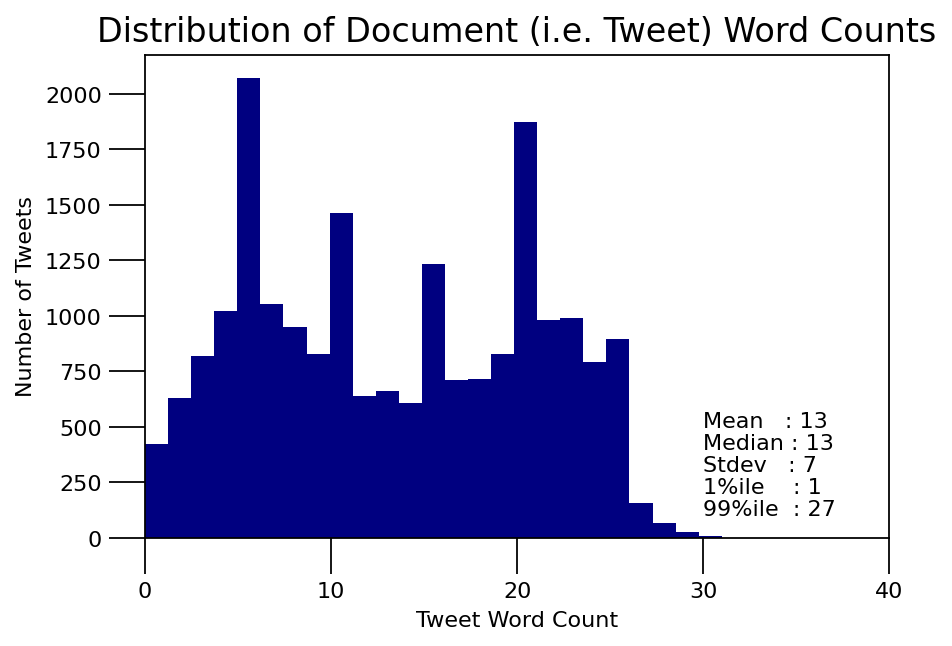

In [101]:
#Plot histogram of word counts in documents- tells us the average length of tweets (after removing stop words).
import numpy as np
# Histogram with tweet words counts for Q1 data
# doc_lens = [len(new_data_as_sentences_nostops[i]) for i in range(len(new_data_as_sentences_nostops))]

# Histogram with tweet words counts for time_slice (i.e. Q2 to Q4 data)
doc_lens = [len(seq_data_as_sentences_nostops[i]) for i in range(len(seq_data_as_sentences_nostops))]
#print(len(doc_lens))

# Plot
#plt.figure(figsize=(100,10))
plt.figure(dpi=160)
plt.tight_layout()
plt.hist(doc_lens, bins = 25, color='navy')
plt.text(30,500,"Mean   : " + str(round(np.mean(doc_lens))))
plt.text(30, 400,"Median : " + str(round(np.median(doc_lens))))
plt.text(30, 300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(30,  200, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(30,  100, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 40), ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,40,5))
plt.title('Distribution of Document (i.e. Tweet) Word Counts', fontdict=dict(size=15))
plt.show()